<a href="https://colab.research.google.com/github/valentina-s/stand_mapping/blob/master/notebooks/0X_Sandbox/valentina_discriminative_loss_training_stand_mapping_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a modificaiton of Unet Segmentation with Discriminative Loss:

https://github.com/nyoki-mtl/pytorch-discriminative-loss

[Semantic Instance Segmentation with a Discriminative Loss Funtion](https://arxiv.org/abs/1708.02551)

In this version we have set the discriminative cost to zero, and removed all instance references. It requires the branch `stand-mapping` from https://github.com/valentina-s/pytorch-discriminative-loss.

### Experiment 1

Vanilla U-net:

3 inputs: RGB

4 targets: 1=water, 2=forest, 3=field, 4=developed

In [ ]:
import numpy as np
import os
import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from torch.autograd import Variable
from torchvision import transforms
from tqdm.notebook import tqdm

In [ ]:
from urllib.request import urlopen
exec(urlopen("http://colab-monitor.smankusors.com/track.py").read())
_colabMonitor = ColabMonitor().start()

Now live at : http://colab-monitor.smankusors.com/6013ef4115103


In [ ]:
# setting the devicide to cuda if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
# uncomment to download repo files
!git clone --branch stand-mapping https://github.com/valentina-s/pytorch-discriminative-loss

Cloning into 'pytorch-discriminative-loss'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 49 (delta 12), reused 18 (delta 10), pack-reused 26
Unpacking objects: 100% (49/49), done.


In [ ]:
cd pytorch-discriminative-loss/notebook

/content/pytorch-discriminative-loss/notebook/pytorch-discriminative-loss/notebook


Before running download the model from [model.pth](https://drive.google.com/drive/folders/1ihcqYr9PptELUZjHVL7jT4LXB3VpfxNt), and put it under `pytorch-discriminative-loss/model/`

In [ ]:
import sys
sys.path.append('../src/')

from model import UNet
from loss import DiscriminativeLoss

In [ ]:
# set the number of input and output classes
N_CLASSES = 4
N_CHANNELS = 4

In [ ]:
# Initialize the model (set number of input and output channels)
model = UNet(in_ch=N_CHANNELS, out_ch=N_CLASSES).to(device)

In [ ]:
# load drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
LOCAL_CHIP_DIR = '/content/chips'
REMOTE_ROOT_DIR = '/content/drive/Shareddrives/stand_mapping/data/processed/training_tiles/'

In [ ]:
! mkdir {LOCAL_CHIP_DIR}
! mkdir {LOCAL_CHIP_DIR}/washington
! mkdir {LOCAL_CHIP_DIR}/oregon


In [ ]:
! cp {REMOTE_ROOT_DIR}washington/chips/*naip*.npy {LOCAL_CHIP_DIR}/washington
! cp {REMOTE_ROOT_DIR}oregon/chips/*naip*.npy {LOCAL_CHIP_DIR}/oregon
! cp {REMOTE_ROOT_DIR}washington/chips/*semantic*.npy {LOCAL_CHIP_DIR}/washington
! cp {REMOTE_ROOT_DIR}oregon/chips/*semantic*.npy {LOCAL_CHIP_DIR}/oregon

# ! cp {REMOTE_ROOT_DIR}washington/chips/*.npz {LOCAL_CHIP_DIR}
# ! cp {REMOTE_ROOT_DIR}oregon/chips/*.npz {LOCAL_CHIP_DIR}

In [ ]:
# # set paths
# # ROOT_DIR = '/content/drive/Shareddrives/stand_mapping/'
# # CHIP_PATH = 'data/processed/training_tiles/washington/chips'

# ROOT_DIR = '/content/'
# CHIP_PATH = 'chips'

In [ ]:
naip = np.load(os.path.join(LOCAL_CHIP_DIR, 'washington', '109965_dnr_2017_naip_013.npy')) # gp-usfs, okanogan-usfs, blm, 
sem = np.load(os.path.join(LOCAL_CHIP_DIR, 'washington', '109965_dnr_2017_semantic_013.npy'))
naip.shape, sem.shape

((1024, 1024, 4), (1024, 1024, 1))

In [ ]:
naip_chip_mean = [74.77060828, 92.60867138, 81.82211117, 122.17832602]  # R, G, B, NIR
naip_chip_std = [31.83725084, 30.74003338, 16.31047271, 43.92487841]  # R, G, B, NIR
naip_rgb_mean = [74.77060828, 92.60867138, 81.82211117]
naip_rgb_std = [31.83725084, 30.74003338, 16.31047271]

In [ ]:
# FILE_TYPE = 'chips'
# ROOT_DIR = '/content/drive/Shareddrives/stand_mapping/data/processed/training_tiles'

# paths = []
# for state_name in ['oregon', 'washington']:
#     for root, dirnames, files in os.walk(os.path.join(ROOT_DIR, state_name, FILE_TYPE)):
#         for f in files:
#             if '.npz' in f:
#                 paths.append(os.path.join(root, f))

# len(paths)

In [ ]:
FILE_TYPE = 'chips'
ROOT_DIR = '/content/drive/Shareddrives/stand_mapping/data/processed/training_tiles'

paths = [f for f in glob.glob(os.path.join(LOCAL_CHIP_DIR, '*naip*.npy'))]
len(paths)

0

In [ ]:
train_paths = [f for f in glob.glob(os.path.join(LOCAL_CHIP_DIR, 'washington', '*naip*.npy'))]
test_paths = [f for f in glob.glob(os.path.join(LOCAL_CHIP_DIR, 'oregon', '*naip*.npy'))]
print(len(train_paths))
print(len(test_paths))

288
241


In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, paths_to_chips, n_classes, transform=None, target_transform=None):
        super(SegmentationDataset, self).__init__()
        self.input_paths = paths_to_chips
        self.n_classes = n_classes
        self.transform = transform
        self.target_transform = target_transform
        
    def __getitem__(self, index):
        path = self.input_paths[index]

        # input = np.load(path)[:,:,:3] # RGB only, drop NIR
        input = np.load(path) # all four channels, RGB + NIR
        input = np.moveaxis(input,-1,0) # move channels to first dimension
        input = torch.FloatTensor(input)

        target = np.load(path.replace('naip', 'semantic')) 
        target = np.moveaxis(target, -1,0)
        target = torch.LongTensor(target)
        nodata = torch.BoolTensor(target == 0)
        target = target - 1

        if self.transform:
            input = self.transform(input)
        if self.target_transform:
            target = self.target_transform(target)
            nodata = self.target_transform(nodata)

        target[nodata] = 1 # we will need to mask these values when scoring

        # #convert targets to one hot
        # target = label2binary_mask(target, n_classes = self.n_classes)
        # return torch.FloatTensor(input), torch.LongTensor(target)
        return input, target, nodata

    def __len__(self):
        return len(self.input_paths)

In [ ]:
# class OneHotTransformer:
#     """Transforms a tensor into 1-hot encoding."""

#     def __init__(self, num_classes):
#         self.num_classes = num_classes

#     def __call__(self, x):
#         num_classes = self.num_classes
#         return F.one_hot(x, num_classes).permute(-1,0,1) # move channels to front, then H,W

In [ ]:
input_transformer = transforms.Compose([
    transforms.Resize((256,256), interpolation=2), # bilinear interpolation to 256x256
    # transforms.Normalize(naip_rgb_mean, naip_rgb_std),
    transforms.Normalize(naip_chip_mean, naip_chip_std),
])

target_transformer = transforms.Compose([
    transforms.Resize((256,256), interpolation=0), # nearest neighbor interpolation to 256x256
])

In [ ]:
# here we create train and test datasets

In [ ]:
train_dataset = SegmentationDataset(train_paths,
                              n_classes = N_CLASSES,
                              transform=input_transformer,
                              target_transform=target_transformer
                              )

In [ ]:
train_dataset[0][0].size(), train_dataset[0][1].size(), train_dataset[0][2].size()

(torch.Size([4, 256, 256]),
 torch.Size([1, 256, 256]),
 torch.Size([1, 256, 256]))

In [ ]:
test_dataset = SegmentationDataset(test_paths,
                              n_classes = N_CLASSES,
                              transform=input_transformer,
                              target_transform=target_transformer
                              )

In [ ]:
# here we create train and test dataloaders

In [ ]:
# create indeces to split train_dataset further to train and validation sets
train_val_ratio = 0.8
dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(train_val_ratio * dataset_size))
train_indices, val_indices = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

In [ ]:
# train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=10,
                        num_workers=2, pin_memory=True,
                        sampler=train_sampler)


In [ ]:
# validation dataloader
val_dataloader = DataLoader(train_dataset, batch_size=10,
                        num_workers=2, pin_memory=True, 
                        sampler=val_sampler)

In [ ]:
# test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=10,
                        shuffle=True, num_workers=2, 
                        pin_memory=True)

In [ ]:
import matplotlib.pyplot as plt
class inverse_normalize:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, y):
        x = y.new(*y.size())
        for i in range(x.shape[0]):
            x[i, :, :] = y[i, :, :] * self.std[i] + self.mean[i]
        return x

# invert = inverse_normalize(naip_rgb_mean, naip_rgb_std)
invert = inverse_normalize(naip_chip_mean, naip_chip_std)

In [ ]:
COLOR_MAP = {
    0: [0,0,0], # none, nodata
    1: [0,0,1], # water
    2: [0,0.5,0], # trees
    3: [0.5,1,0.5], # field
    4: [0.5,0.375,0.375], # developed
}

def recolor_landcover(lc_img, cmap, soft=False, num_classes=4):
  cover_colors = np.zeros((lc_img.shape[0], lc_img.shape[1], 3))
  if not soft:
      for cov in np.unique(lc_img):
          mask = lc_img == cov
          cover_colors[mask] = cmap[cov]
  if soft: # we're given the probability of each class for each pixel
      for i in range(num_classes - 1):
          cover_colors[:,:,0] += lc_img[:,:,i] * cmap[i+1][0] # R
          cover_colors[:,:,1] += lc_img[:,:,i] * cmap[i+1][1] # G
          cover_colors[:,:,2] += lc_img[:,:,i] * cmap[i+1][2] # B

  return (cover_colors * 255).astype(np.uint8)

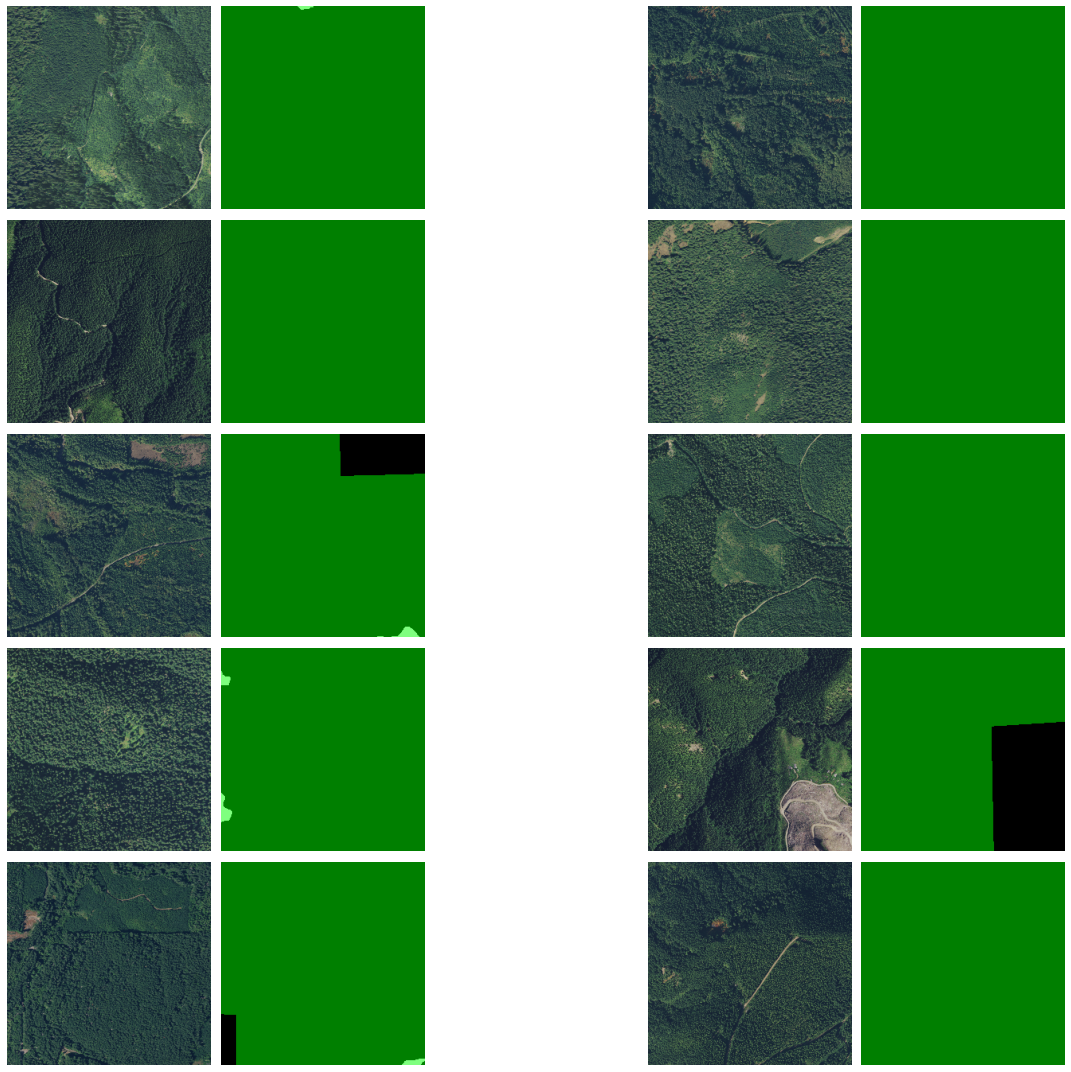

In [ ]:
NUM_CHIPS = 10
fig, axs = plt.subplots(nrows=NUM_CHIPS//2, ncols=5, figsize=(5*3, 3*NUM_CHIPS//2))
for i in range(NUM_CHIPS):
  chip_num = np.random.randint(0, len(train_paths))
  row_num = i//2
  j = 0 if i % 2 == 0 else 3
  axs[row_num, j].imshow(np.moveaxis(invert(train_dataset[chip_num][0]).numpy()[0:3,:,:], 0,-1).astype(np.uint8))
  cover = (train_dataset[chip_num][1]).numpy().squeeze().astype(np.uint8) + 1
  nodata = (train_dataset[chip_num][2]).numpy().squeeze()
  cover[nodata] = 0
  cover_color = recolor_landcover(cover, COLOR_MAP)
  axs[row_num, j+1].imshow(cover_color)

for ax in axs.ravel():
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# 512x3
# 0:1x256x256 (boundary binary)
# 1:2x256x256 (semantic binary: complements)
# 2:8x256x256(for each instance: 8 sticks)

# #imagesx3
# 0:1 x rows x columns original image 
# 1:2 x rows x columns (semantic binary class: complements)
# 2: # instances x rows x columns(for each instance: instance mask)

In [ ]:
# Loss Function

# Here we will set all discriminative loss parameters to zero, so that we first try bare bones U-net
criterion_disc = DiscriminativeLoss(delta_var=0.5,
                                    delta_dist=1.5,
                                    norm=2,
                                    alpha=0.0, 
                                    beta=0.0, 
                                    gamma=0.0,
                                    usegpu=True).to(device)
criterion_ce = nn.CrossEntropyLoss(reduction='none').to(device)


In [ ]:
# Optimizer
parameters = model.parameters()
optimizer = optim.SGD(parameters, lr=0.01, momentum=0.9, weight_decay=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min',
                                                 factor=0.1,
                                                 patience=10,
                                                 verbose=True)

Run a training loop.

In [ ]:
import warnings
#part of the message is also okay
warnings.filterwarnings("ignore", message="Default upsampling behavior") 

# Train
model_dir = ('/content/drive/Shareddrives/stand_mapping/models')
os.makedirs(model_dir, exist_ok=True)

best_loss = np.inf
NUM_EPOCHS = 50
for epoch in range(NUM_EPOCHS):
    
    ### Training ###
    with tqdm(total=int(np.ceil(len(train_indices) / 10)), # 10 samples per batch
              desc=f'epoch {epoch+1}') as pbar:
        # print(f'epoch : {epoch+1}', end=' ')

        model.train()
        disc_losses = []
        ce_losses = []

        batch_num = 1
        for batched in train_dataloader:
            # images, sem_labels, ins_labels = batched
            images, sem_labels, nodata = batched
            # images = images.cuda()
            # sem_labels = sem_labels.cuda()
            # nodata = nodata.cuda()

            images = Variable(images).to(device)
            sem_labels = Variable(sem_labels).to(device)
            nodata = Variable(nodata).to(device)

            model.zero_grad()

            # sem_predict, ins_predict = model(images)
            sem_predict = model(images)
            loss = 0

            # Discriminative Loss
            # disc_loss = criterion_disc(ins_predict,
            #                           ins_labels,
            #                           [n_sticks] * len(images))
            # loss += disc_loss
            # disc_losses.append(disc_loss.cpu().data.numpy())

            # Cross Entropy Loss
            # _, sem_labels_ce = sem_labels.argmax(1)
            #ce_loss = criterion_ce(sem_predict.permute(0, 2, 3, 1)\
            #                      .contiguous().view(-1, 2), sem_labels_ce.view(-1))
            
            mask = ~nodata
            ce_loss = criterion_ce(sem_predict, sem_labels.squeeze())
            ce_loss = mask*ce_loss
            ce_loss = torch.sum(ce_loss.flatten(start_dim=1), axis=0) # Sums the loss per image
            # train_loss, val_loss = ce_loss[:8], ce_loss[8:]
            ce_loss = torch.mean(ce_loss) # loss per batch
            loss += ce_loss
            ce_losses.append(ce_loss.cpu().data.numpy())
            
            loss.backward()
            optimizer.step()
            pbar.update()
        # disc_loss = np.mean(disc_losses)
        ce_loss = np.mean(ce_losses)
        # print(f'DiscriminativeLoss: {disc_loss:.4f}')
        print(f'Train CrossEntropyLoss: {ce_loss:.4f}', end = ' ')
        #scheduler.step(disc_loss)
        loss = ce_loss
        
        # save model based on ce_loss (not discriminative)
        if loss < best_loss:
            best_loss = loss
            modelname = 'exp002_model.pth'
            torch.save(model.state_dict(), os.path.join(model_dir, modelname))

    ### Validation ###
    with torch.no_grad():
        model.eval()
        val_losses = []
        for batched in val_dataloader:
            images, sem_labels, nodata = batched
            # images = images.cuda()
            # sem_labels = sem_labels.cuda()
            images = Variable(images).to(device)
            sem_labels = Variable(sem_labels).to(device)
            nodata = Variable(nodata).to(device)

            #ins_labels = Variable(ins_labels).cuda()
            model.zero_grad()

            # sem_predict, ins_predict = model(images)
            sem_predict = model(images)            
            model.eval()
              
            # calculate loss within mask
            mask = ~nodata
            val_loss = criterion_ce(sem_predict, sem_labels.squeeze())
            val_loss = mask*val_loss
            val_loss = torch.sum(val_loss.flatten(start_dim=1), axis=0) # Sums the loss per image
            val_loss = torch.mean(val_loss) # loss per batch
            val_losses.append(val_loss.cpu().data.numpy())

        val_loss = np.mean(val_losses)
        print(f'Validation CrossEntropyLoss: {val_loss:.4f}', end = ' ')


    

Train CrossEntropyLoss: 6.0732 
Validation CrossEntropyLoss: 5.2071 

Train CrossEntropyLoss: 1.7450 
Validation CrossEntropyLoss: 2.5633 

Train CrossEntropyLoss: 1.7219 
Validation CrossEntropyLoss: 1.9888 

Train CrossEntropyLoss: 1.4607 
Validation CrossEntropyLoss: 6.3842 

Train CrossEntropyLoss: 1.4136 
Validation CrossEntropyLoss: 2.5289 

Train CrossEntropyLoss: 1.1690 
Validation CrossEntropyLoss: 1.4889 

Train CrossEntropyLoss: 1.1797 
Validation CrossEntropyLoss: 1.3424 

Train CrossEntropyLoss: 1.1888 
Validation CrossEntropyLoss: 2.4496 

Train CrossEntropyLoss: 1.2250 
Validation CrossEntropyLoss: 1.6095 

Train CrossEntropyLoss: 1.0958 
Validation CrossEntropyLoss: 1.4010 

Train CrossEntropyLoss: 1.1773 
Validation CrossEntropyLoss: 1.4418 

Train CrossEntropyLoss: 1.0796 
Validation CrossEntropyLoss: 1.7428 

Train CrossEntropyLoss: 1.0706 
Validation CrossEntropyLoss: 1.2087 

Train CrossEntropyLoss: 1.0182 
Validation CrossEntropyLoss: 1.2513 

Train CrossEntropyLoss: 1.1048 
Validation CrossEntropyLoss: 1.3689 

Train CrossEntropyLoss: 1.0462 
Validation CrossEntropyLoss: 1.1943 

Train CrossEntropyLoss: 0.9823 
Validation CrossEntropyLoss: 1.0458 

Train CrossEntropyLoss: 1.1866 
Validation CrossEntropyLoss: 1.2106 

Train CrossEntropyLoss: 0.9247 
Validation CrossEntropyLoss: 1.0883 

Train CrossEntropyLoss: 0.9401 
Validation CrossEntropyLoss: 1.9795 

Train CrossEntropyLoss: 0.8430 
Validation CrossEntropyLoss: 1.2860 

Train CrossEntropyLoss: 0.8738 
Validation CrossEntropyLoss: 1.0842 

Train CrossEntropyLoss: 0.8290 
Validation CrossEntropyLoss: 1.1229 

Train CrossEntropyLoss: 0.7147 
Validation CrossEntropyLoss: 1.3420 

Train CrossEntropyLoss: 0.8659 
Validation CrossEntropyLoss: 1.1437 

Train CrossEntropyLoss: 0.7964 
Validation CrossEntropyLoss: 1.6256 

Train CrossEntropyLoss: 0.8601 
Validation CrossEntropyLoss: 1.0372 

Train CrossEntropyLoss: 0.9470 
Validation CrossEntropyLoss: 0.9636 

Train CrossEntropyLoss: 1.0180 
Validation CrossEntropyLoss: 1.2088 

Train CrossEntropyLoss: 0.8984 
Validation CrossEntropyLoss: 1.2536 

Train CrossEntropyLoss: 0.7963 
Validation CrossEntropyLoss: 1.0267 

Train CrossEntropyLoss: 0.8174 
Validation CrossEntropyLoss: 1.0904 

Train CrossEntropyLoss: 0.7323 
Validation CrossEntropyLoss: 0.8882 

Train CrossEntropyLoss: 0.6594 
Validation CrossEntropyLoss: 1.0771 

Train CrossEntropyLoss: 0.7478 
Validation CrossEntropyLoss: 1.0458 

Train CrossEntropyLoss: 0.7277 
Validation CrossEntropyLoss: 2.1055 

Train CrossEntropyLoss: 0.6844 
Validation CrossEntropyLoss: 1.2707 

Train CrossEntropyLoss: 0.9226 
Validation CrossEntropyLoss: 1.3380 

Train CrossEntropyLoss: 0.6292 
Validation CrossEntropyLoss: 1.1756 

Train CrossEntropyLoss: 0.6251 
Validation CrossEntropyLoss: 1.2056 

Train CrossEntropyLoss: 0.7444 
Validation CrossEntropyLoss: 1.1798 

Train CrossEntropyLoss: 0.6721 
Validation CrossEntropyLoss: 1.0262 

Train CrossEntropyLoss: 0.6113 
Validation CrossEntropyLoss: 1.2720 

Train CrossEntropyLoss: 0.7198 
Validation CrossEntropyLoss: 1.6862 

Train CrossEntropyLoss: 0.6373 
Validation CrossEntropyLoss: 1.9375 

Train CrossEntropyLoss: 0.7081 
Validation CrossEntropyLoss: 1.3068 

Train CrossEntropyLoss: 0.7394 
Validation CrossEntropyLoss: 1.0533 

Train CrossEntropyLoss: 0.6733 
Validation CrossEntropyLoss: 1.3115 

Train CrossEntropyLoss: 0.6087 
Validation CrossEntropyLoss: 1.3631 

Train CrossEntropyLoss: 0.6227 
Validation CrossEntropyLoss: 1.2344 

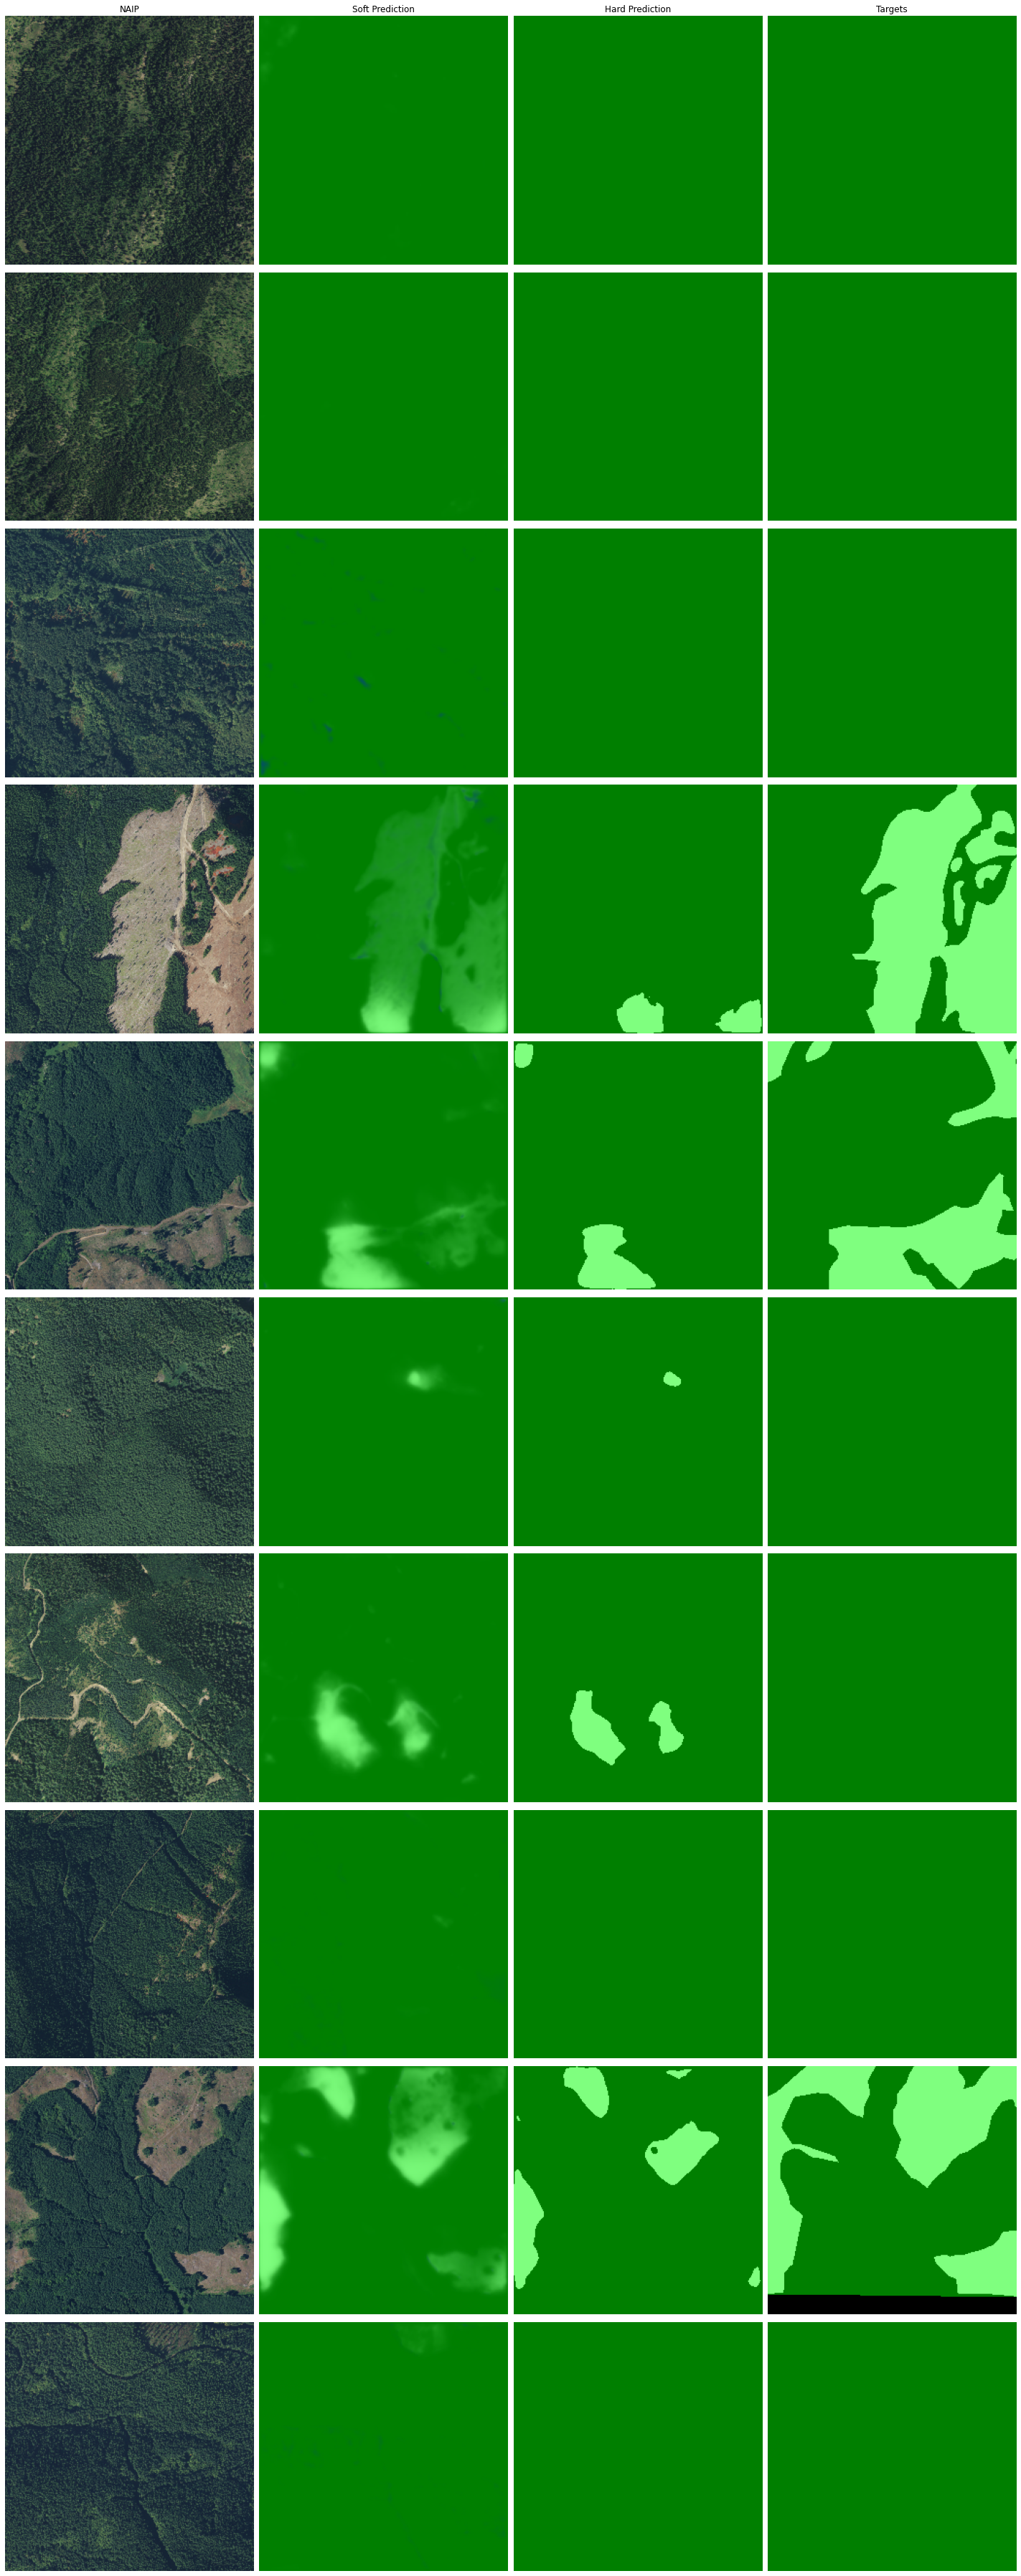

In [ ]:
# display results from the last batch
num_chips = images.shape[0]
fig, axs = plt.subplots(NUM_CHIPS,4, figsize=(20,5*num_chips))
for i in range(num_chips):
    axs[i, 0].imshow(invert(images[i].detach().cpu()).permute(1,2,0).numpy().astype(np.uint8)[:,:,0:3])
    pred_proba = F.softmax(sem_predict, dim=1)[i].permute(1,2,0).cpu().detach().numpy()
    axs[i, 1].imshow(recolor_landcover(pred_proba, COLOR_MAP, soft=True))
    axs[i, 2].imshow(recolor_landcover(sem_predict[i].argmax(dim=0).cpu().detach().numpy() + 1, COLOR_MAP))
    labels = sem_labels[i][0]
    labels[nodata[i][0]] = -1
    axs[i, 3].imshow(recolor_landcover(labels.cpu().detach().numpy() + 1, COLOR_MAP))
for ax in axs.ravel():
    ax.axis('off')
axs[0,0].set_title('NAIP')
axs[0,1].set_title('Soft Prediction')
axs[0,2].set_title('Hard Prediction')
axs[0,3].set_title('Targets')

plt.tight_layout()
plt.show()